In [157]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, top_k_accuracy_score,  mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xarray as xr
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt 

def top_k_acc(y_true, y_pred, k=1):

    top = np.argpartition(-y_pred, k, axis=1)[:, :k]
    top_targets = (y_true[np.arange(y_true.shape[0])[:, None], top])
    
    return (top_targets.sum() / y_true.shape[0] * 100).round(2)

def get_indices_w_plume(encoder_data, threshold=1e-7):
    """
    Searches all sensors across time and returns sample indices where ch4 is detected.
    Args:
        data: xr.DataArray
    Returns: numpy array of indicies where at least one sensor sees some plume
    """
    ch4 = encoder_data[:, 1:, :, -1, 0].values  # pull ch4 timeseries from all ch4 sensors
    reshaped_ch4 = ch4.reshape(ch4.shape[0], ch4.shape[1] * ch4.shape[2])  # reshape (samples, sensors * time)
    return np.argwhere((reshaped_ch4 > threshold).any(axis=1)).flatten()

def discard_accuracy(y_true, y_pred, n_thresh=50, k=1):

    accuracies = []
    if k > 1:
        l = []
        for kk in range(1, k + 1):
            l.append(y_pred[range(y_pred.shape[0]), np.argpartition(-y_pred, k, axis=1)[:, kk-1:kk].flatten()])
        top_k_stacked = np.stack(l)
        top_k_probs = np.max(top_k_stacked, axis=0)
    else:        
        top_k_probs = y_pred[range(y_pred.shape[0]), np.argpartition(-y_pred, k, axis=1)[:, :k].flatten()]

    p_thresh = np.linspace(0, 0.99, n_thresh)
    for p in p_thresh:
        indices = np.where(top_k_probs > p)[0]
        acc = top_k_acc(y_true[indices], y_pred[indices], k=k)
        accuracies.append(acc)
    return accuracies, p_thresh

def plot_leak_rate_cm(truth, preds, ax, leak_min=0, leak_max=50, interval=5, normalization=None, savefig=False, colorbar=False,
                      savepath="./"):
    """
    Plot a confusion matrix of leak rate predictions binned by specified ranges.
    Args:
        truth (np.array): Actual leak rate predictions
        preds (np.array): Predicted Leak rates
        leak_min (int): Minimum leak rate to include in dataset (exclusive)
        leak_max (int): Maximum leak rate to include in dataset (inclusive)
        interval (int): Interval length to bin predictions by
        normalization: Normalization type. Accepts None, "pred", or "true"
        savefig (bool): weather to save the figure out
        savepath (str): Path to save figure
    """
    indices = np.argwhere((truth > leak_min) & (truth <= leak_max))
    leak_rate = truth[indices]
    preds = preds[indices]
    cat_leak_true = np.zeros(shape=leak_rate.squeeze().shape)
    cat_leak_preds = np.zeros(shape=leak_rate.squeeze().shape)
    for i, x in enumerate(np.arange(leak_min, leak_max, interval)):
        true_indices = np.argwhere((leak_rate >= x) & (leak_rate < x + interval))
        pred_indices = np.argwhere((preds.squeeze() >= x) & (preds.squeeze() < x + interval))
        cat_leak_true[true_indices] = i
        cat_leak_preds[pred_indices] = i

    cm = confusion_matrix(cat_leak_true, cat_leak_preds, normalize=normalization)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, vmax=1, display_labels=[f"{x} > LR <= {x + interval}" for x in
                                                                       np.arange(leak_min, leak_max, interval)])

    return disp

def get_leak_rate_cm(truth, preds, leak_min=0, leak_max=50, interval=5, normalization=None):
    """
    Plot a confusion matrix of leak rate predictions binned by specified ranges.
    Args:
        truth (np.array): Actual leak rate predictions
        preds (np.array): Predicted Leak rates
        leak_min (int): Minimum leak rate to include in dataset (exclusive)
        leak_max (int): Maximum leak rate to include in dataset (inclusive)
        interval (int): Interval length to bin predictions by
        normalization: Normalization type. Accepts None, "pred", or "true"
        savefig (bool): weather to save the figure out
        savepath (str): Path to save figure
    """
    indices = np.argwhere((truth > leak_min) & (truth <= leak_max))
    leak_rate = truth[indices]
    preds = preds[indices]
    cat_leak_true = np.zeros(shape=leak_rate.squeeze().shape)
    cat_leak_preds = np.zeros(shape=leak_rate.squeeze().shape)
    for i, x in enumerate(np.arange(leak_min, leak_max, interval)):
        true_indices = np.argwhere((leak_rate >= x) & (leak_rate < x + interval))
        pred_indices = np.argwhere((preds.squeeze() >= x) & (preds.squeeze() < x + interval))
        cat_leak_true[true_indices] = i
        cat_leak_preds[pred_indices] = i

    cm = confusion_matrix(cat_leak_true, cat_leak_preds, normalize=normalization)
    return cm

def get_cm(data, group_type, normalize=None):

    truth = data[f"true_{group_type}"].values
    preds = data[f"pred_{group_type}"].values
    labels = np.unique(truth)
    
    return confusion_matrix(truth, preds, normalize=normalize), labels

In [5]:
ds = xr.open_dataset('/glade/derecho/scratch/cbecker/seals_evaluation/2024-09-13_1959/model_output_2024-09-13_1959.nc')

In [6]:
remove_blind = True
subset_leak_rate = True
blind_threshold = 0
leak_rate_threshold = 10
if remove_blind:
    indices = get_indices_w_plume(ds['encoder_input'], threshold=blind_threshold)
    ds_sub = ds.isel(sample=indices)

if subset_leak_rate:
    ds_sub = ds_sub.where(ds_sub['target_leak_rate'] <= leak_rate_threshold, drop=True)

In [134]:
for group_type in ["equip_ID", "group", "equip_type"]:
    print(f"Total Positive Prediction Accuracy for {group_type}: {accuracy_score(ds_sub[f'true_{group_type}'], ds_sub[f'pred_{group_type}'])}")

Total Positive Prediction Accuracy for equip_ID: 0.6243467987458536
Total Positive Prediction Accuracy for group: 0.8982520713106436
Total Positive Prediction Accuracy for equip_type: 0.8599233577195134


In [154]:
true_lr = ds_sub['target_leak_rate']
pred_lr = ds_sub['leak_rate_pred']
print(f"Mean Absolute Error: {mean_absolute_error(true_lr, pred_lr)}")
print(f"Mean Squared Error: {mean_squared_error(true_lr, pred_lr)}")
print(f"Root Mean Squared Error: {root_mean_squared_error(true_lr, pred_lr)}")
print(f"Sharpness: {np.array(np.var(true_lr) /  np.var(pred_lr))}")

Mean Absolute Error: 0.7857188582420349
Mean Squared Error: 1.7106331586837769
Root Mean Squared Error: 1.30791175365448
Sharpness: 1.1593401432037354


In [103]:
metrics = {}
for group_type in ["equip_ID", "equip_type", "group"]:
    metrics[group_type] = {}
    cm = confusion_matrix(ds_sub[f'true_{group_type}'].values, ds_sub[f'pred_{group_type}'].values, labels=np.unique(ds[f'true_{group_type}']))
    OBS = cm.sum(axis=1)
    PREDS = cm.sum(axis=0)
    TOTAL = cm.sum()
    FP = PREDS - np.diag(cm)
    FN = OBS - np.diag(cm)
    TP = np.diag(cm)
    TN = TOTAL - (FP + FN + TP)
    metrics[group_type]['groupings'] = sorted(np.unique(ds_sub[f'true_{group_type}'].values))
    metrics[group_type]['cm'] = cm
    metrics[group_type]['OBS'] = OBS
    metrics[group_type]['PREDS'] = PREDS
    metrics[group_type]['TOTAL'] = TOTAL
    metrics[group_type]['FP'] = FP
    metrics[group_type]['FN'] = FN
    metrics[group_type]['TP'] = TP
    metrics[group_type]['TN'] = TN
    metrics[group_type]['TPR'] = TP / (TP + FN) # Sensitivity, hit rate, recall, or true positive rate
    metrics[group_type]['TNR'] = TN / (TN + FP) # Specificity or true negative rate
    metrics[group_type]['PPV'] = TP / (TP + FP) # Precision or positive predictive value
    metrics[group_type]['NPV'] = TN / (TN + FN) # Negative predictive value
    metrics[group_type]['FPR'] = FP / (FP + TN) # Fall out or false positive rate
    metrics[group_type]['FNR'] = FN / (TP + FN) # False negative rate
    metrics[group_type]['FDR'] = FP / (TP + FP) # False discovery rate
    metrics[group_type]['FAR'] = (PREDS - TP) / PREDS # False Alarm Rate
    metrics[group_type]['ACC'] = (TP + TN).sum() / (TP + FP + FN + TN).sum() # Overall accuracy

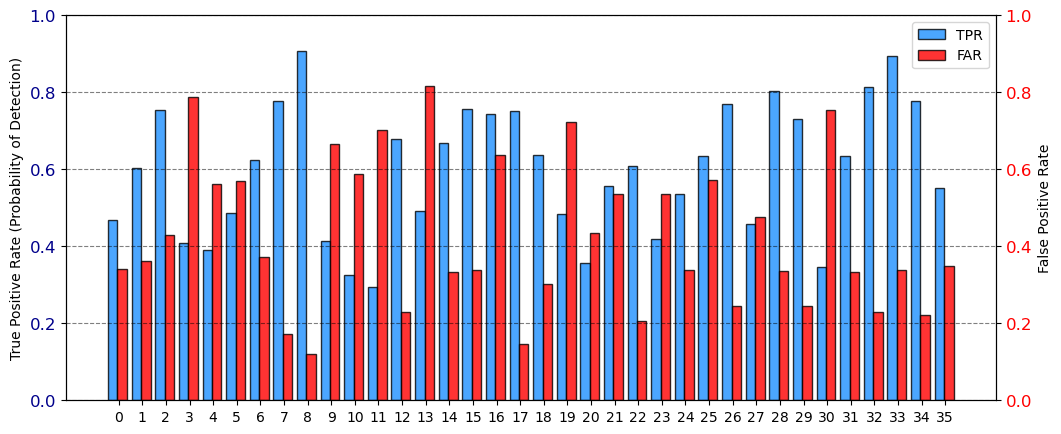

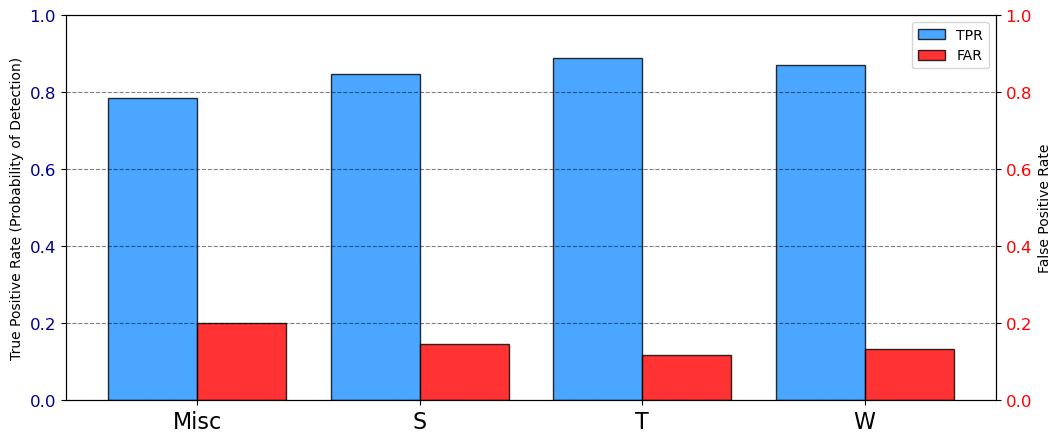

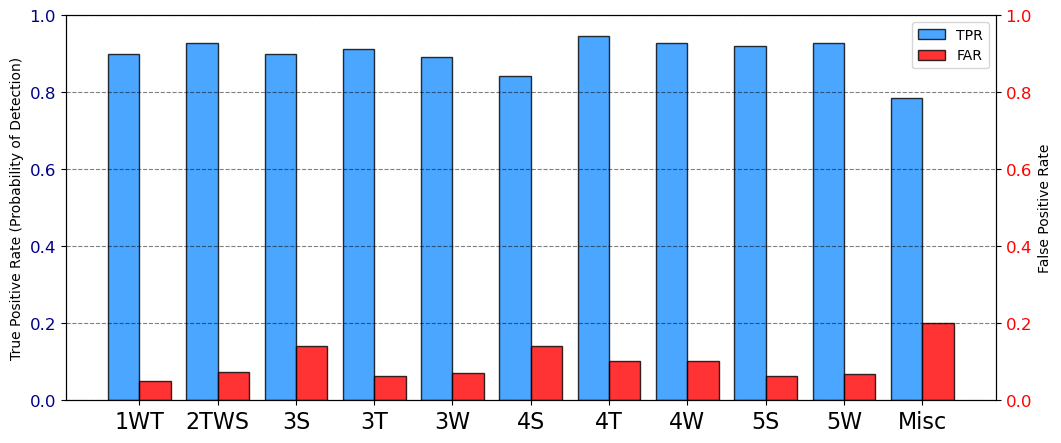

In [124]:
for key, group_type in metrics.items():

    xlabels = group_type['groupings']
    if key == 'equip_ID':
        xticks = np.arange(0.25, 36.25, 1)
        xlabels = np.array(group_type['groupings']).astype(int)
        fs = 10
    elif key == 'group':
        xticks = np.arange(0.2, 11.2, 1)
        xlabels = group_type['groupings']
        fs = 16
    elif key == 'equip_type':
        xticks = np.arange(0.2, 4.2, 1)
        xlabels = group_type['groupings']
        fs = 16
        
    TPR = group_type['TPR']
    FPR = group_type['FAR']
    fig, ax = plt.subplots(figsize=(12, 5))
    ax2 = ax.twinx()
    x = np.arange(len(np.unique(ds_sub[f'true_{key}'].values)))
    ax.bar(x, TPR, width=0.4, color='dodgerblue', edgecolor='k', alpha=0.8, label='TPR')
    ax.bar(x + 0.4, FPR, width=0.4, color='r', edgecolor='k', alpha=0.8, label='FAR')
    ax.set_xticks(group_type['x_ticks'], xlabels, fontsize=fs)
    ax.set_yticks(np.arange(0, 1.2, 0.2), np.arange(0, 1.2, 0.2).round(1), color='darkblue', alpha=1, fontsize=12)
    ax2.set_yticks(np.arange(0, 1.2, 0.2), np.arange(0, 1.2, 0.2).round(1), color='r', alpha=1, fontsize=12)
    ax.set_ylabel('True Positive Rate (Probability of Detection)')
    ax2.set_ylabel('False Positive Rate')
    ax.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', color='k', alpha=0.5)
    ax.legend()

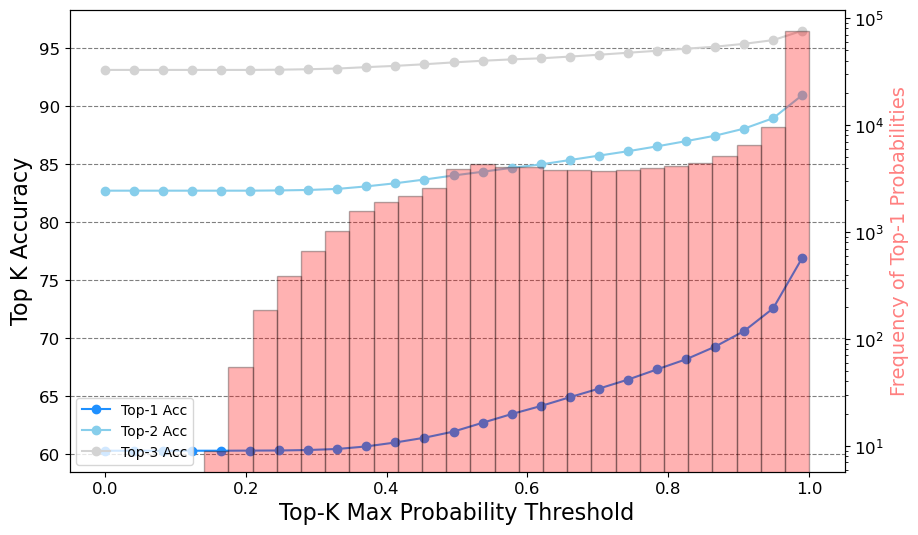

In [126]:
fig, axes = plt.subplots(1, figsize=(10, 6))
axes2 = axes.twinx()
colors = ['dodgerblue', 'skyblue', 'lightgrey']
for k in range(1, 4):
    y, x = discard_accuracy(ds_sub['target_leak_loc'].values, ds_sub['leak_loc_preds'].values, k=k, n_thresh=25)
    axes.plot(x, y, "-o", color=colors[k-1], label=f"Top-{k} Acc")
axes2.hist(ds['leak_loc_preds'].values[range(ds['leak_loc_preds'].values.shape[0]), np.argpartition(-ds['leak_loc_preds'].values, 1, axis=1)[:, :1].flatten()], bins=25, alpha=0.3, color='r', log=True, edgecolor='k')
axes.legend(loc="lower left")
axes.set_ylabel("Top K Accuracy", fontsize=16)
axes2.set_ylabel("Frequency of Top-1 Probabilities", fontsize=14, color='r', alpha=0.5)
axes.set_xlabel("Top-K Max Probability Threshold", fontsize=16)
axes.grid(axis='y', linestyle='--', color='k', alpha=0.5)
axes2.yaxis.set_tick_params(labelsize=12)
axes.yaxis.set_tick_params(labelsize=12)
axes.xaxis.set_tick_params(labelsize=12)
plt.show()

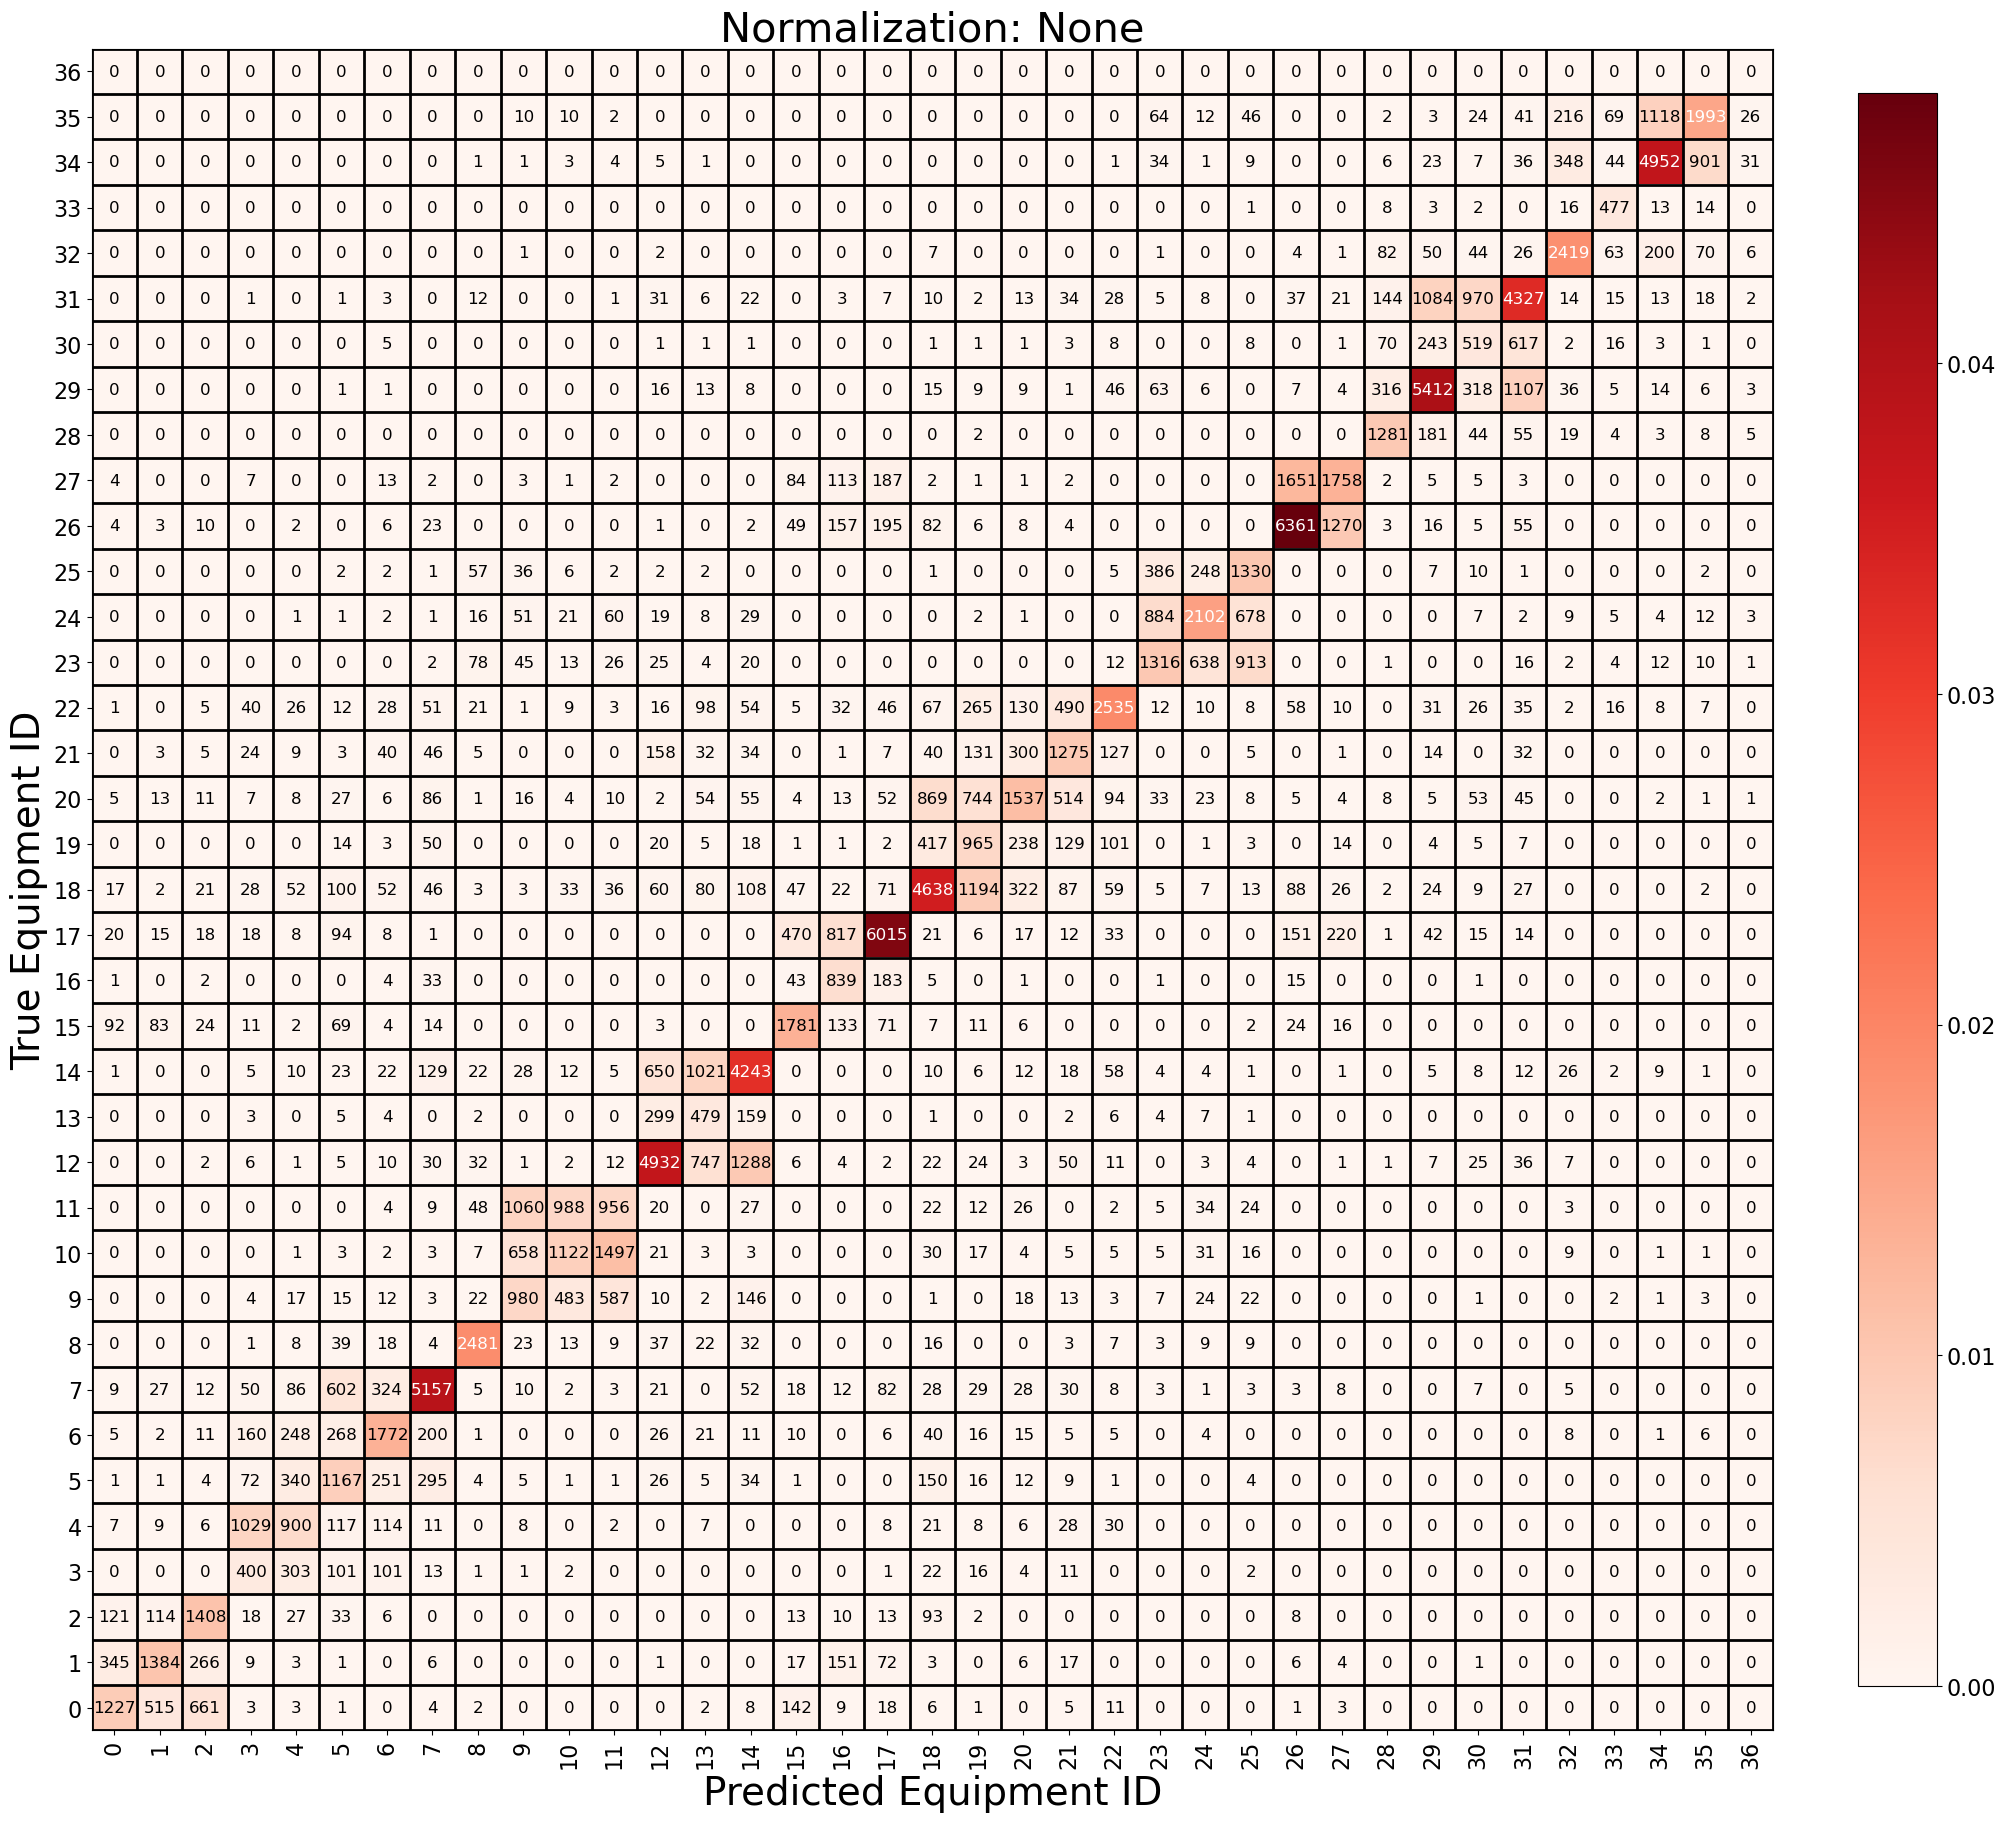

In [137]:
fig, ax = plt.subplots(figsize=(20, 20), constrained_layout=True)
group_types = ['equip_ID', 'group', 'equip_type']
normalization = [None, 'true', 'pred']

cm = cm, labels = get_cm(ds_sub, group_type='equip_ID', normalize=None)
accuracies = cm/cm.sum()

im = ax.imshow(accuracies, cmap='Reds')
ax.invert_yaxis()
classes = np.arange(37)
ax.set_xticks(range(len(classes)), classes, rotation=90)
ax.set_yticks(range(len(classes)), classes)

# Minor ticks
ax.set_xticks(np.arange(-.5, len(classes), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(classes), 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

for i in range(len(classes)):
    for j in range(len(classes)):
        color='k' if accuracies[i,j] < 0.015 else 'white'
        a = f'{cm[i,j]}'
        ax.annotate(a, (j, i), 
                    color=color, va='center', ha='center', fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Predicted Equipment ID', fontsize=28)
ax.set_ylabel('True Equipment ID', fontsize=28)
cb = plt.colorbar(im, ax=ax, shrink=0.8)
cb.ax.tick_params(labelsize=16)
ax.set_title(f"Normalization: {'none'.title()}", fontsize=30)
# plt.savefig("/glade/derecho/scratch/cbecker/seals_20240911/cm_equip_id_none.png", dpi=300, bbox_inches="tight")
plt.show()

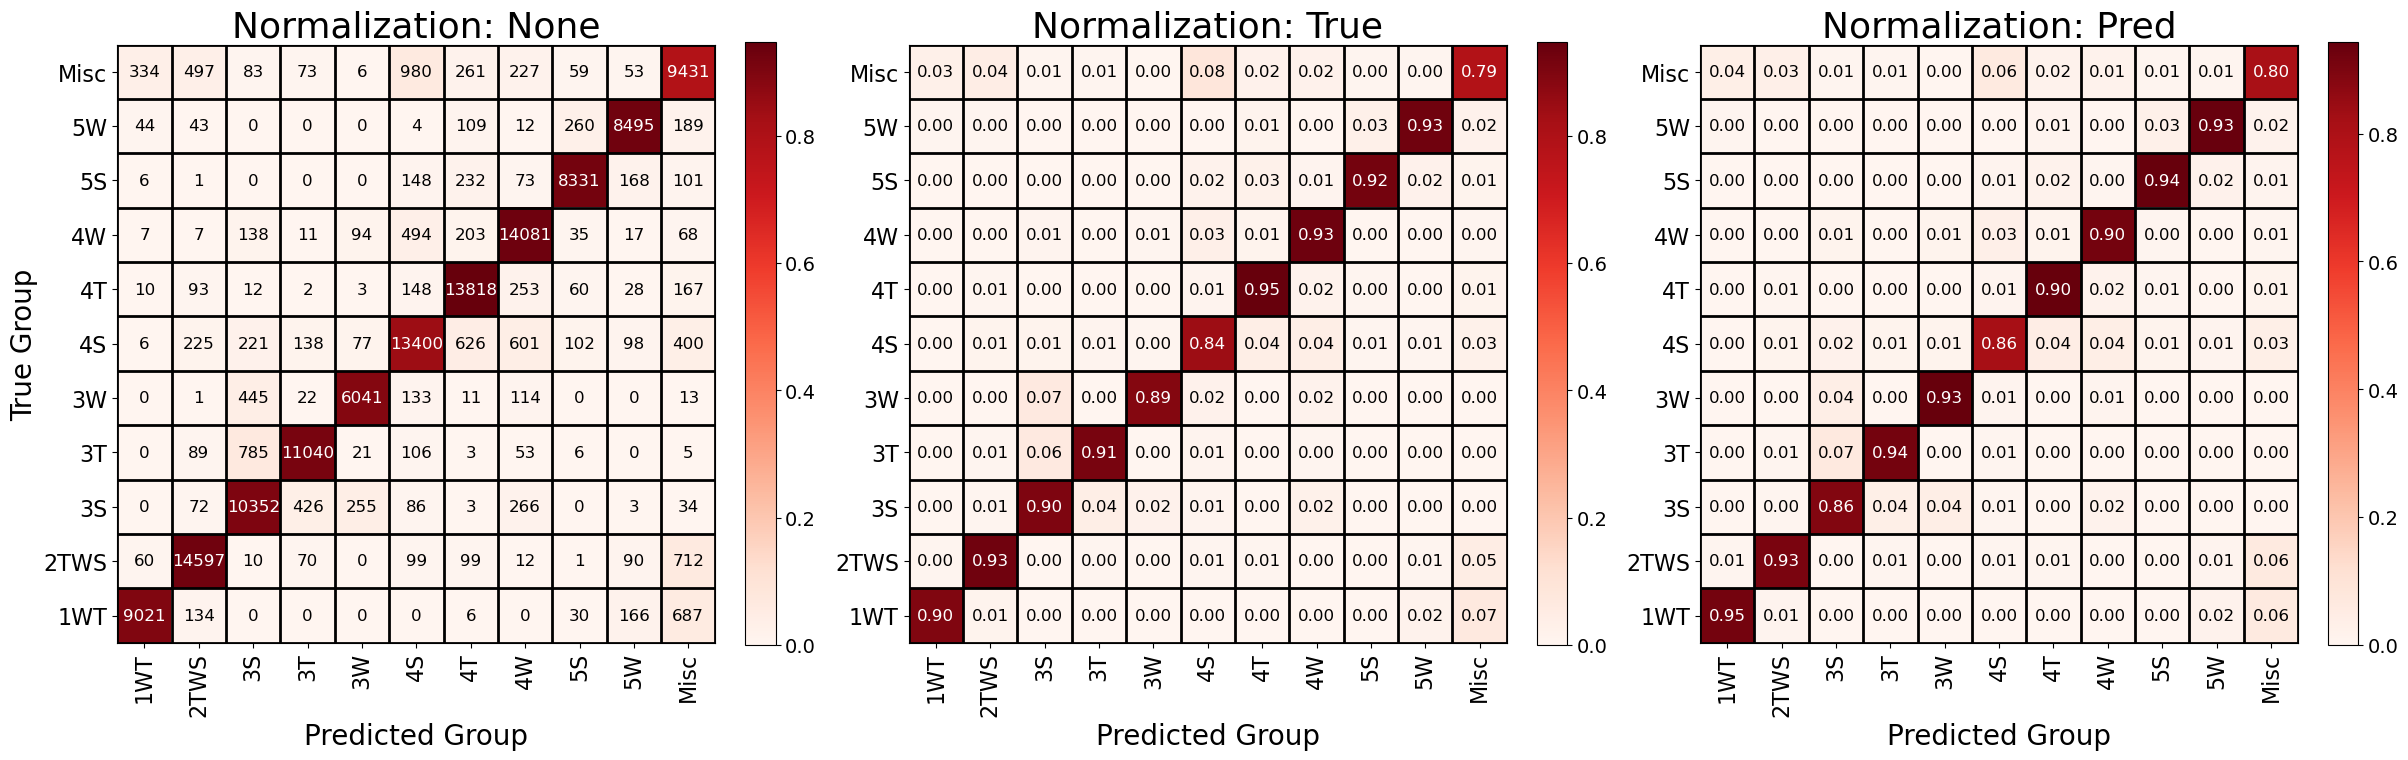

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(24,8), constrained_layout=True)
group_types = ['equip_ID', 'group', 'equip_type']
normalization = [None, 'true', 'pred']

for ix, ax in enumerate(axes.ravel()):
    cm = cm, labels = get_cm(ds_sub, group_type='group', normalize=normalization[ix])
    accuracies = cm/cm.sum(1)

    im = ax.imshow(accuracies, cmap='Reds')
    ax.invert_yaxis()
    classes = labels
    ax.set_xticks(range(len(classes)), classes, rotation=90)
    ax.set_yticks(range(len(classes)), classes)
    
    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(classes), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(classes), 1), minor=True)
    
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    
    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            color='k' if accuracies[i,j] < 0.5 else 'white'
            if ix == 0:
                a = f'{cm[i,j]}'
            else:
                a = f'{cm[i,j]:.2f}'
            ax.annotate(a, (j, i), 
                        color=color, va='center', ha='center', fontsize=12)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    cb = plt.colorbar(im, ax=ax, shrink=0.8)
    cb.ax.tick_params(labelsize=14)
    ax.set_xlabel('Predicted Group', fontsize=20)
    if ix == 0:
        ax.set_ylabel('True Group', fontsize=20)

    ax.set_title(f"Normalization: {str(normalization[ix]).title()}", fontsize=26)
plt.show()

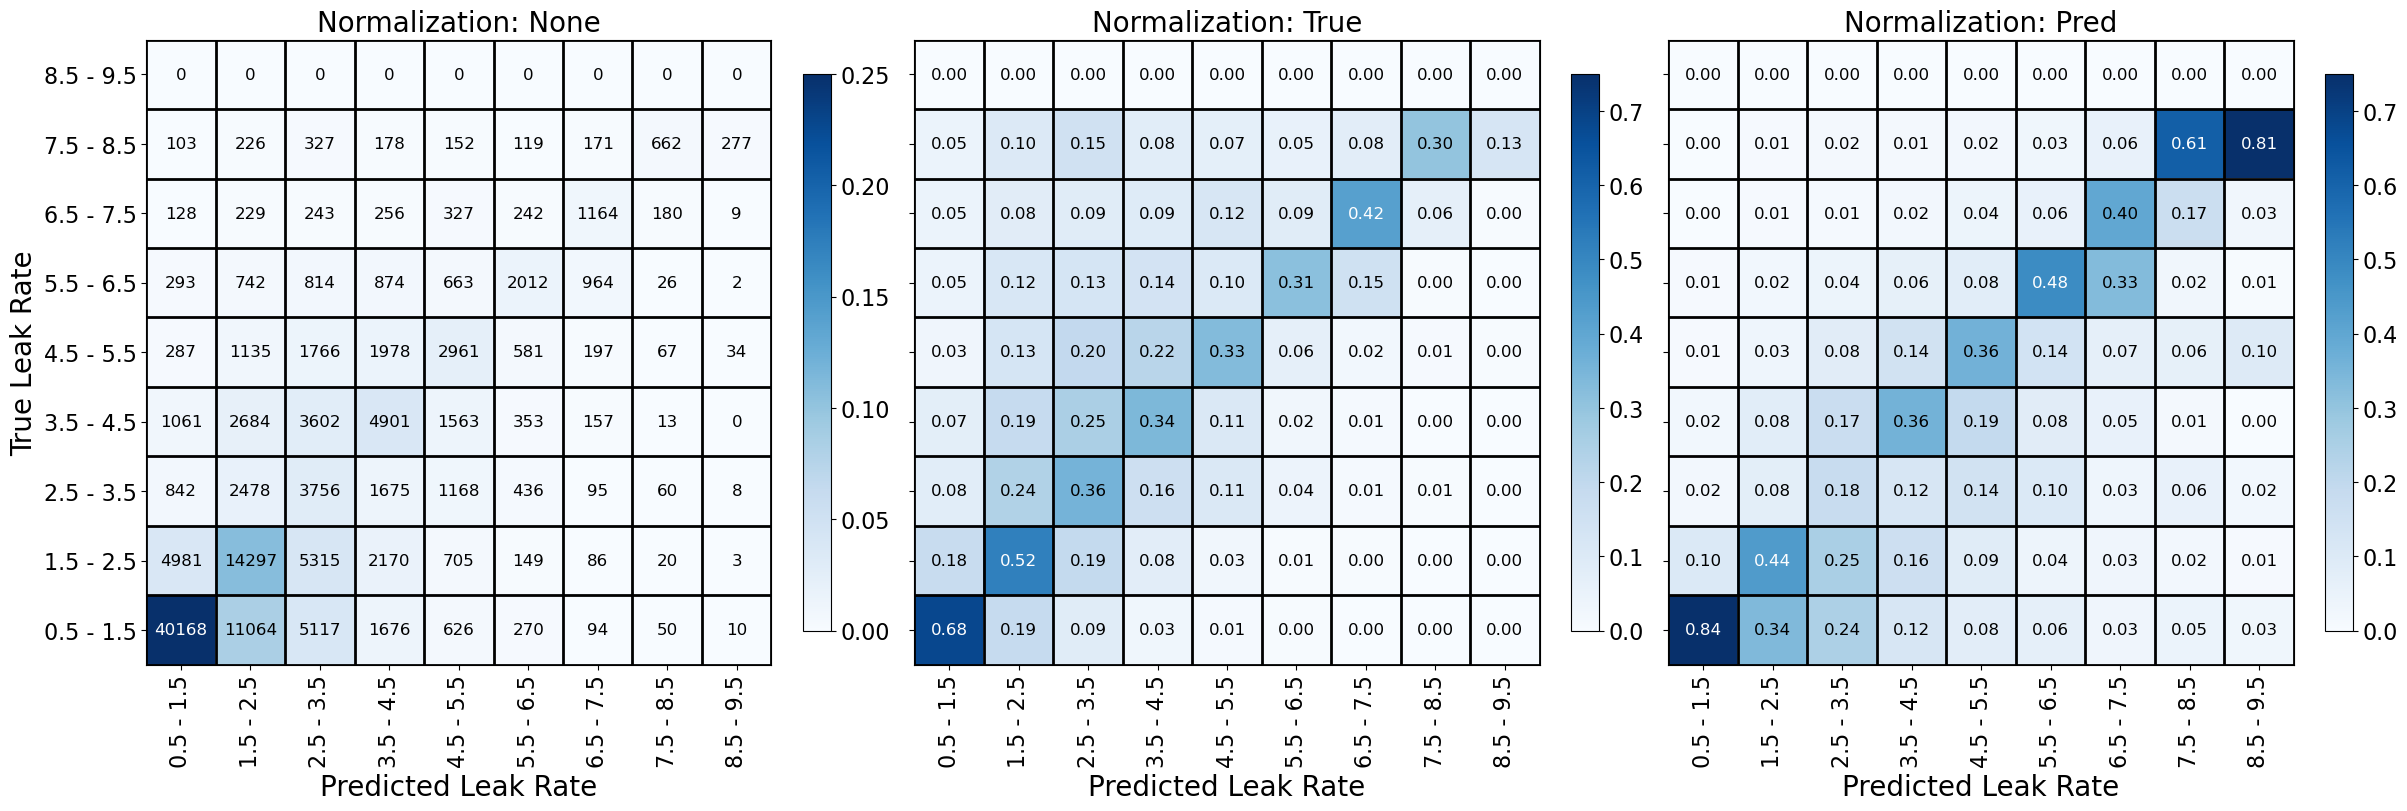

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(24,8), constrained_layout=True)
group_types = ['equip_ID', 'group', 'equip_type']
normalization = [None, 'true', 'pred']
leak_min = 0.5
leak_max = 9.5
interval = 1

for ix, ax in enumerate(axes.ravel()):
    # cm = cm, labels = get_cm(ds_sub, group_type='equip_type', normalize=normalization[ix])
    cm = get_leak_rate_cm(ds_sub['target_leak_rate'].values, ds_sub['leak_rate_pred'].values, leak_min=leak_min, leak_max=leak_max, interval=interval, normalization=normalization[ix])
    accuracies = cm/cm.sum()
    # classes = [f"{x} < LR <= {x + interval}" for x in np.arange(leak_min, leak_max, interval)]
    classes = [f"{x} - {x + interval}" for x in np.arange(leak_min, leak_max, interval)]

    if ix == 0:
        im = ax.imshow(accuracies, cmap='Blues', vmax=0.25)
    else:
        im = ax.imshow(cm, cmap='Blues', vmax=0.75)
    ax.invert_yaxis()

    
    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(classes), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(classes), 1), minor=True)
    ax.set_xticks(range(len(classes)), classes, rotation=90)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    
    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)

    for i in range(len(classes)):
        for j in range(len(classes)):
            
            if ix == 0:
                a = f'{cm[i,j]}'
                color='k' if accuracies[i,j] < 0.15 else 'white'
                ax.set_yticks(range(len(classes)), classes)
            else:
                a = f'{cm[i,j]:.2f}'
                color='k' if cm[i,j] < 0.4 else 'white'
                ax.set_yticklabels([])
            ax.annotate(a, (j, i), 
                        color=color, va='center', ha='center', fontsize=12)
    
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_xlabel('Predicted Leak Rate', fontsize=20)
    if ix == 0:
        ax.set_ylabel('True Leak Rate', fontsize=20)
    cb = plt.colorbar(im, ax=ax, shrink=0.8)
    cb.ax.tick_params(labelsize=16)
    ax.set_title(f"Normalization: {str(normalization[ix]).title()}", fontsize=20)
plt.show()